In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [2]:
# Uninstall any existing TensorFlow version
!pip uninstall -y tensorflow

# Uninstall existing TensorFlow and ml-dtypes to avoid conflicts
!pip uninstall -y tensorflow ml-dtypes

# Install compatible TensorFlow version
!pip install tensorflow==2.15.0

# Install other dependencies
!pip install tensorflow-decision-forests==1.8.1 tensorflow-text==2.15.0 tf-keras==2.15.1 wurlitzer ml-dtypes>=0.3.1


Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: ml-dtypes 0.2.0
Uninstalling ml-dtypes-0.2.0:
  Successfully uninstalled ml-dtypes-0.2.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorstore 0.1.60 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.


In [3]:
# Verify GPU availability
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-07-12 15:55:29.072475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 15:55:29.072525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 15:55:29.073915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  2


In [4]:
## Importing the libraries
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
import unicodedata
import spacy

import re
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
from warnings import filterwarnings
filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Embedding
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
df = pd.read_csv('/kaggle/input/quora-question-pairs/train.csv.zip')

In [6]:
df.shape

(404290, 6)

In [7]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
#df_test = pd.read_csv('/kaggle/input/quora-question-pairs/test.csv.zip')

In [9]:
df_sample = df.sample(100000,random_state=2)
df_sample

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0
...,...,...,...,...,...,...
147622,147622,185363,232946,Why do you live a life?,Why do people live? What is reason for you to ...,1
353951,353951,23995,483033,Why are Golden Retriever dogs with blue eyes s...,How do I train Golden Retriever dogs with blue...,0
251765,251765,177088,357433,How do I learn computer practically?,What is the best way to learn computer languages?,0
150383,150383,221786,236690,I want to start a new business in India (appro...,What are some good ideas for small industries ...,0


In [10]:
df_sample.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       1
is_duplicate    0
dtype: int64

In [11]:
df_sample = df_sample.dropna()

#### Step-by-Step Process
1. Data Preparation: Load and preprocess the data.
2. Text Vectorization: Convert text to numerical representations.
3. Model Building: Create models using Simple RNN, LSTM, and GRU.
4. Model Training: Train the models.
5. Model Evaluation: Evaluate the models.

### Text Preprocessing and Vectorization

- We'll use Tokenizer and pad_sequences from Keras to preprocess and vectorize the text.

In [12]:
# Define a preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\r', '', text)
    return text


# Apply preprocessing
df_sample['question1_cleaned'] = df_sample['question1'].apply(preprocess_text)
df_sample['question2_cleaned'] = df_sample['question2'].apply(preprocess_text)

In [13]:
# Tokenize the questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([df_sample['question1_cleaned'], df_sample['question2_cleaned']]))

# Convert text to sequences
sequences_1 = tokenizer.texts_to_sequences(df_sample['question1_cleaned'])
sequences_2 = tokenizer.texts_to_sequences(df_sample['question2_cleaned'])

In [14]:
# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because indexing starts from 1

In [15]:
vocab_size

49529

In [16]:
#df_sample['question1_cleaned'][0]

In [17]:
#sequences_1[0]

#### Analyze the Distribution of Sequence Lengths

In [18]:
# Example sequences (replace with your actual sequences)
sequences = sequences_1 + sequences_2

# Compute lengths of sequences
sequence_lengths = [len(seq) for seq in sequences]

In [19]:
len(sequences_1),len(sequences_2),len(sequences)

(99999, 99999, 199998)

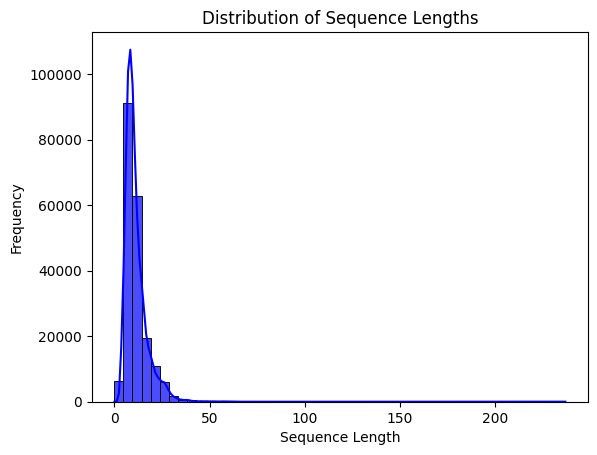

In [20]:
# Plot the distribution of sequence lengths
sns.histplot(sequence_lengths, bins=50, kde=True, color='blue', alpha=0.7)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()


In [21]:
# Print some statistics
print(f"Average sequence length: {np.mean(sequence_lengths)}")
print(f"Median sequence length: {np.median(sequence_lengths)}")
print(f"95th percentile length: {np.percentile(sequence_lengths, 98)}")

Average sequence length: 11.15059150591506
Median sequence length: 10.0
95th percentile length: 28.0


In [22]:
# Pad the sequences
max_len = 30
x1 = pad_sequences(sequences_1, maxlen=max_len)
x2 = pad_sequences(sequences_2, maxlen=max_len)

x = np.concatenate((x1,x2),axis = 1)

# Create the target variable
y = df_sample['is_duplicate'].values

# Split the data into training and validation sets
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.3,shuffle=True,stratify=y,
                                                 random_state=42)

In [23]:
np.concatenate((x1,x2),axis = 1).shape

(99999, 60)

In [24]:
# Reshape the target variable to be 2D
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [25]:
y_train.ndim

2

In [26]:
x1.shape,x2.shape

((99999, 30), (99999, 30))

### Simple RNN

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Define the RNN model
model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len * 2),  # Adjusted input length for concatenated sequences
    SimpleRNN(units=128),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Create dummy input to build the model
dummy_input = np.zeros((1, max_len * 2), dtype=int)
model_rnn(dummy_input)

# Compile the model
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=['accuracy','f1_score','precision','recall'])

# Print model summary
print(model_rnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           4952900   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4990533 (19.04 MB)
Trainable params: 4990533 (19.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [28]:
# Train the model
#model_rnn.fit(x_train, y_train, epochs=10, batch_size=32,validation_split=0.2)

### LSTM

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Define the LSTM model
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len * 2),
    LSTM(units=128),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Create dummy input to build the model
dummy_input = np.zeros((1, max_len * 2), dtype=int)
model_lstm(dummy_input)

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics=['accuracy','f1_score','precision','recall'])

# Print model summary
print(model_lstm.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 100)           4952900   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5078469 (19.37 MB)
Trainable params: 5078469 (19.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [30]:
# Train the model
#model_lstm.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

### GRU

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

# Define the LSTM model
model_gru = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len * 2),
    GRU(units=128),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Create dummy input to build the model
dummy_input = np.zeros((1, max_len * 2), dtype=int)
model_gru(dummy_input)

# Compile the model
model_gru.compile(optimizer='adam', loss='binary_crossentropy', 
                   metrics=['accuracy','f1_score','precision','recall'])

# Print model summary
print(model_gru.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 100)           4952900   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5049541 (19.26 MB)
Trainable params: 5049541 (19.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [32]:
# Train the model
#model_gru.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

### Hyperparameter tuning

In [33]:
!pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: keras-tuner
    Found existing installation: keras-tuner 1.4.6
    Uninstalling keras-tuner-1.4.6:
      Successfully uninstalled keras-tuner-1.4.6


In [34]:
from kerastuner import HyperModel, RandomSearch
from tensorflow.keras.layers import Input, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

### Define custom F1 metric

In [35]:
import keras.backend as K

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_score_value = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1_score_value


### RNN Hyper model

In [36]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from keras_tuner import Objective
from tensorflow.keras.callbacks import EarlyStopping


class RNNHyperModel(HyperModel):
    def __init__(self, max_len, max_vocab):
        self.max_len = max_len
        self.max_vocab = max_vocab

    def build(self, hp):
        model = Sequential()
        model.add(Embedding(input_dim=self.max_vocab, output_dim=100, input_length=self.max_len * 2))
        model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=512, step=32)))
        model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=512, step=32),
                        activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='binary_crossentropy',
                      metrics=['accuracy',Precision(), Recall(), f1_score])
        
        return model


### LSTM Hypermodel

In [37]:
class LSTMHyperModel(HyperModel):
    def __init__(self, max_len, max_vocab):
        self.max_len = max_len
        self.max_vocab = max_vocab

    def build(self, hp):
        model = Sequential()
        model.add(Embedding(input_dim=self.max_vocab, output_dim=100, input_length=self.max_len * 2))
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32)))
        model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=512, step=32),
                        activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='binary_crossentropy',
                      metrics=['accuracy',Precision(), Recall(), f1_score])
        
        return model


### GRU Hypermodel

In [38]:
class GRUHyperModel(HyperModel):
    def __init__(self, max_len, max_vocab):
        self.max_len = max_len
        self.max_vocab = max_vocab

    def build(self, hp):
        model = Sequential()
        model.add(Embedding(input_dim=self.max_vocab, output_dim=100, input_length=self.max_len * 2))
        model.add(GRU(units=hp.Int('units', min_value=32, max_value=512, step=32)))
        model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=512, step=32),
                        activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='binary_crossentropy',
                      metrics=['accuracy',Precision(), Recall(), f1_score])
        
        return model


In [39]:


# Assuming you have max_len and max_vocab defined
max_len = 30
max_vocab = vocab_size

# Instantiate hypermodel classes
rnn_hypermodel = RNNHyperModel(max_len, max_vocab)
lstm_hypermodel = LSTMHyperModel(max_len, max_vocab)
gru_hypermodel = GRUHyperModel(max_len, max_vocab)

# Define the tuner (example: RandomSearch)
tuner_rnn = RandomSearch(
    rnn_hypermodel,
    #objective='val_precision',
    objective=Objective("val_f1_score", direction="max"),
    max_trials=10,
    directory='/kaggle/working',
    project_name='rnn_hyperparameter_tuning')

tuner_lstm = RandomSearch(
    lstm_hypermodel,
    #objective='val_precision',
    objective=Objective("val_f1_score", direction="max"),
    max_trials=10,
    directory='/kaggle/working',
    project_name='lstm_hyperparameter_tuning')

tuner_gru = RandomSearch(
    gru_hypermodel,
    #objective='val_precision',
    objective=Objective("val_f1_score", direction="max"),
    max_trials=10,
    directory='/kaggle/working',
    project_name='gru_hyperparameter_tuning')


Reloading Tuner from /kaggle/working/rnn_hyperparameter_tuning/tuner0.json


In [40]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [41]:
# Perform the hyperparameter search for RNN
tuner_rnn.search(x_train, y_train, epochs=10,validation_split = 0.2,batch_size=32,
                 callbacks=[early_stopping])

Trial 10 Complete [00h 10m 44s]
val_f1_score: 0.5933147668838501

Best val_f1_score So Far: 0.6257361769676208
Total elapsed time: 01h 36m 08s


In [42]:
# Perform the hyperparameter search for LSTM
tuner_lstm.search(x_train, y_train, epochs=10, validation_split = 0.2,callbacks=[early_stopping])

Trial 10 Complete [00h 02m 09s]
val_f1_score: 0.6400063037872314

Best val_f1_score So Far: 0.6458404660224915
Total elapsed time: 00h 21m 37s


In [43]:
# Perform the hyperparameter search for GRU
tuner_gru.search(x_train, y_train, epochs=10, validation_split = 0.2,callbacks=[early_stopping])

Trial 10 Complete [00h 03m 09s]
val_f1_score: 0.6308324337005615

Best val_f1_score So Far: 0.6409258842468262
Total elapsed time: 00h 23m 15s


In [44]:
# Get the best model
best_model_rnn = tuner_rnn.get_best_models(num_models=1)[0]
best_model_lstm = tuner_lstm.get_best_models(num_models=1)[0]
best_model_gru = tuner_gru.get_best_models(num_models=1)[0]

# Save the best model
best_model_rnn.save('/kaggle/working/best_model_rnn.h5')  # Save the model in the working directory
best_model_lstm.save('/kaggle/working/best_model_lstm.h5') 
best_model_gru.save('/kaggle/working/best_model_gru.h5') 


In [46]:
# Register the custom metric function with Keras
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'f1_score': f1_score})

In [47]:
from tensorflow.keras.models import load_model

# Load the saved model
best_model_saved_rnn = load_model('/kaggle/working/best_model_rnn.h5')
best_model_saved_lstm = load_model('/kaggle/working/best_model_lstm.h5')
best_model_saved_gru = load_model('/kaggle/working/best_model_gru.h5')


# Evaluate the best models
best_model_saved_rnn.evaluate(x_test, y_test)
best_model_saved_lstm.evaluate(x_test, y_test)
best_model_saved_gru.evaluate(x_test, y_test)


938/938 [==============================] - 4s 4ms/step - loss: 0.5660 - accuracy: 0.7260 - precision: 0.6197 - recall: 0.6604 - f1_score: 0.6302


[0.5660455226898193,
 0.7260000109672546,
 0.6197279095649719,
 0.6603841781616211,
 0.630239725112915]

In [48]:
# Make predictions
y_test_prob_predict_rnn = best_model_saved_rnn.predict(x_test)
y_test_prob_predict_lstm = best_model_saved_lstm.predict(x_test)
y_test_prob_predict_gru = best_model_saved_gru.predict(x_test)

938/938 [==============================] - 2s 2ms/step


In [49]:
y_test_predict_rnn = (y_test_prob_predict_rnn > 0.5).astype(int)
y_test_predict_lstm = (y_test_prob_predict_lstm > 0.5).astype(int)
y_test_predict_gru = (y_test_prob_predict_gru > 0.5).astype(int)

In [50]:
print("---------------------------------------------------------------------")
print("Model Name : RNN")
print("---------------------------------------------------------------------")
print(classification_report(y_test,y_test_predict_rnn))
print("Model Name : LSTM")
print("---------------------------------------------------------------------")
print(classification_report(y_test,y_test_predict_lstm))
print("Model Name : GRU")
print("---------------------------------------------------------------------")
print(classification_report(y_test,y_test_predict_gru))

---------------------------------------------------------------------
Model Name : RNN
---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74     18964
           1       0.57      0.69      0.63     11036

    accuracy                           0.70     30000
   macro avg       0.68      0.69      0.68     30000
weighted avg       0.71      0.70      0.70     30000

Model Name : LSTM
---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.66      0.73     18964
           1       0.57      0.75      0.65     11036

    accuracy                           0.70     30000
   macro avg       0.69      0.71      0.69     30000
weighted avg       0.73      0.70      0.70     30000

Model Name : GRU
---------------------------------------------------------------------
              